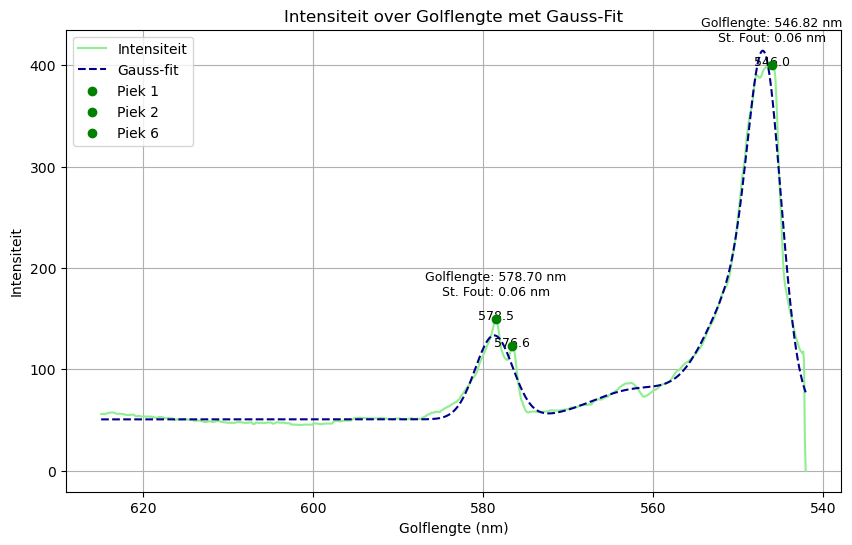

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# Laad de afbeelding
image_path = "C:\\Users\\Gebruiker\\Documents\\kapi.1.png"  # Vervang dit door het pad naar je afbeelding
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Controleer of de afbeelding goed is geladen
if img is None:
    print(f"Fout: Kan de afbeelding '{image_path}' niet laden.")
else:
    # Meet de intensiteit over de pixels (langs de y-as), maar negeer de eerste 100 pixels
    intensity = np.sum(img, axis=0)[100:]  # Verwijder de eerste 100 pixels
    x_pixels = np.arange(100, len(intensity) + 100)  # Maak een nieuwe x-as vanaf pixel 100

    # Zet x_pixels en intensity om naar float64
    x_pixels = x_pixels.astype(np.float64)

    # Zoek pieken in de gegevens (met een drempel en minimumafstand)
    peaks, properties = find_peaks(intensity, height=0.2 * max(intensity), distance=10)
    
    # Controleer of er pieken zijn gevonden
    if len(peaks) == 0:
        print("Geen pieken gevonden.")
    else:
        # Definieer de gecombineerde Gaussfunctie (meerdere pieken)
        def multi_gauss(x, *params):
            # Verwacht een lijst van (A, x0, sigma) sets voor elke piek
            y = np.zeros_like(x)
            n = len(params) // 3  # Aantal pieken
            for i in range(n):
                A, x0, sigma = params[3*i:3*i+3]
                y += A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
            return y
        
        # Bepaal de startwaarden voor de Gauss-functies
        initial_guess = []
        for peak in peaks:
            initial_guess += [intensity[peak], x_pixels[peak], 10]  # A, x0, sigma voor elke piek

        # Stel grenzen in voor de parameters van de Gaussfunctie (deze helpen om de optimizer te sturen)
        lower_bounds = [0] * len(initial_guess)  # Minimale waarden voor A, x0 en sigma voor elke piek
        upper_bounds = [max(intensity) * 2] * len(initial_guess)  # Maximale waarden voor A, x0 en sigma voor elke piek

        # Pas de gecombineerde Gaussfunctie aan op de intensiteitsdata met grenzen
        try:
            popt, pcov = curve_fit(multi_gauss, x_pixels, intensity, p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=5000)

            # Verkrijg de Gauss-fit
            fitted_intensity = multi_gauss(x_pixels, *popt)

            # Lineaire transformatie van de pixelpositie naar golflengte (op basis van bekende piekposities)
            pixel_to_wavelength = np.polyfit([x_pixels[peaks[0]], x_pixels[peaks[1]], x_pixels[peaks[5]]],
                                            [579, 576, 546], 1)
            poly = np.poly1d(pixel_to_wavelength)

            # Pas de transformatie toe op alle pixelposities
            x_wavelengths = poly(x_pixels)

            # Schaal de intensiteit naar een bereik van 0 tot 400
            min_intensity = np.min(intensity)  # Minimale intensiteit
            max_intensity = np.max(intensity)  # Maximale intensiteit
            new_min_y = 0  # Nieuwe minimum y-waarde (0)
            new_max_y = 400  # Nieuwe maximum y-waarde (400)

            # Lineaire schaal van de intensiteit naar de nieuwe schaal (0 naar 400)
            intensity_scaled = ((intensity - min_intensity) / (max_intensity - min_intensity)) * (new_max_y - new_min_y) + new_min_y
            fitted_intensity_scaled = ((fitted_intensity - min_intensity) / (max_intensity - min_intensity)) * (new_max_y - new_min_y) + new_min_y

            # Plot de originele intensiteit (ruw) en de Gauss-fit
            plt.figure(figsize=(10, 6))
            plt.plot(x_wavelengths, intensity_scaled, label="Intensiteit", color="lightgreen")  # Gebruik de ruwe intensiteit in lichtgroen
            plt.plot(x_wavelengths, fitted_intensity_scaled, label="Gauss-fit", color="darkblue", linestyle="--")  # Gauss-fit in donkerblauw
            
            # Markeer alleen de pieken die je wilt (negeer pieken 3, 4, 5 en 7)
            peaks_to_mark = [0, 1, 5]  # Markeer alleen pieken 1, 2 en 6 (index 0, 1, 6)
            for peak_idx in peaks_to_mark:
                plt.scatter(x_wavelengths[peaks[peak_idx]], intensity_scaled[peaks[peak_idx]], color="green", label=f"Piek {peak_idx + 1}", zorder=5)
            
            # Toon de piek posities op de grafiek
            for peak_idx in peaks_to_mark:
                plt.text(x_wavelengths[peaks[peak_idx]], intensity_scaled[peaks[peak_idx]], f"{x_wavelengths[peaks[peak_idx]]:.1f}", color="black", fontsize=9, ha='center')
            
            # Piek 1 en 6: Toon golflengte en standaardfout
            for peak_idx in [0, 5]:  # Piek 1 en Piek 6
                x0_pixel = popt[3 * peak_idx + 1]  # Haal x0 op voor deze piek
                x0_wavelength = poly(x0_pixel)  # Transformatie naar golflengte
                
                # Standaarddeviatie voor de pixelpositie (x0)
                sigma = popt[3 * peak_idx + 2]  # Standaarddeviatie voor de piek
                sigma_err = np.sqrt(pcov[3 * peak_idx + 2, 3 * peak_idx + 2])  # Standaardfout voor sigma
                
                # Standaardfout voor de golflengte (afgeleid van de standaardfout van x0)
                dpoly_dx = poly.deriv()  # Afgeleide van de polyfunctie (slope)
                wavelength_err = sigma_err * np.abs(dpoly_dx(x0_pixel))  # Standaardfout van de golflengte
                
                # Plaats de tekst in de grafiek
                plt.text(x_wavelengths[peaks[peak_idx]], intensity_scaled[peaks[peak_idx]] + 20,
                         f"Golflengte: {x0_wavelength:.2f} nm\nSt. Fout: {wavelength_err:.2f} nm",  # Toon standaardfout van de golflengte
                         color="black", fontsize=9, ha='center', va='bottom')

            plt.title("Intensiteit over Golflengte met Gauss-Fit")
            plt.xlabel("Golflengte (nm)")
            plt.ylabel("Intensiteit")
            plt.legend()
            plt.grid(True)

            # Spiegelt de grafiek (x-as omkeren)
            plt.gca().invert_xaxis()

            plt.show()

        except RuntimeError as e:
            print(f"Fout bij het uitvoeren van de Gauss-fit: {e}")
